In [1]:
import sys
sys.path.append('../')
from cifar.cifarRawCorrupted import get_original_loaders, get_corrupt_loaders

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Test Corrupt Loaders

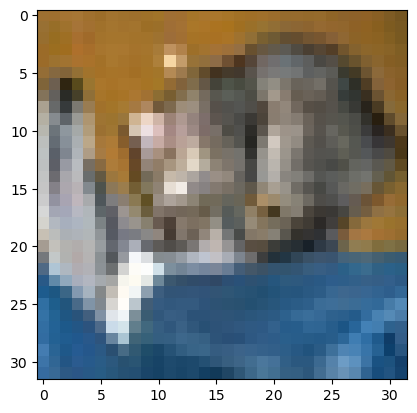

In [17]:
plt.imshow((imk[0].numpy().transpose(1,2,0)*255).astype(np.uint8))


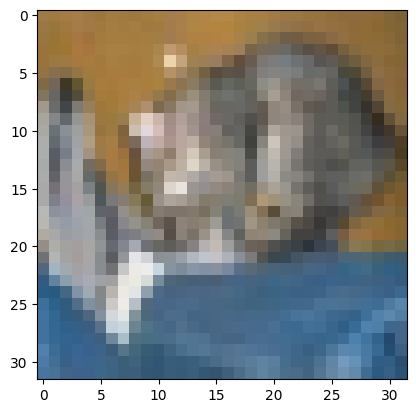

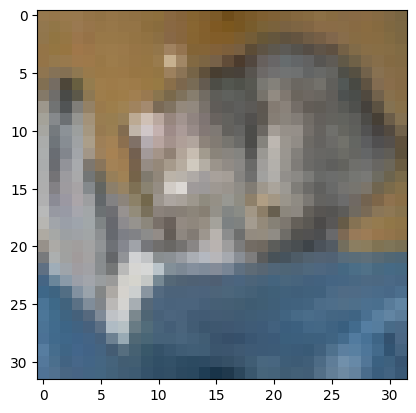

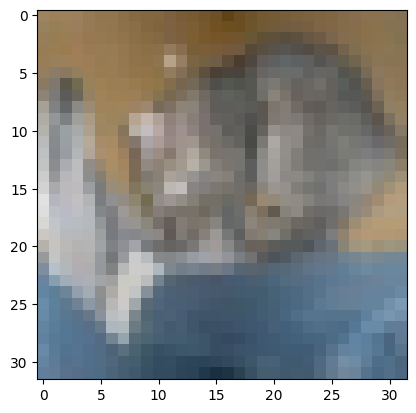

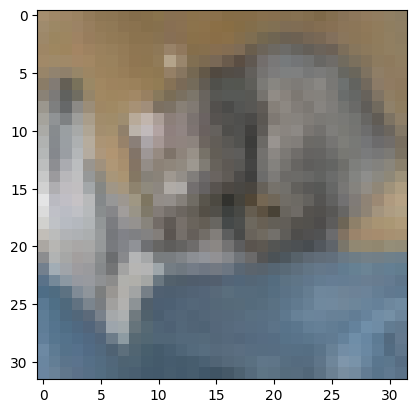

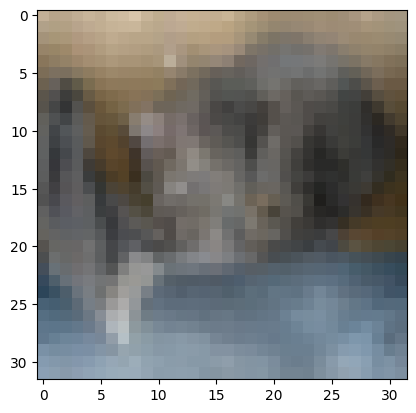

In [104]:
# severity 

for sev in [1, 2, 3, 4, 5]:
    test_loader_corrupt = get_corrupt_loader(batch_size=1024, corruption_type='fog', severity=sev, model_name='clip')
    ims, _, _ = next(iter(test_loader_corrupt))
    plt.imshow(ims[0].cpu().numpy())
    plt.show()

In [92]:
corruption_images_list.shape

(50000, 32, 32, 3)

In [63]:
gaus = np.load('/DS/brn-vision/work/side_pr/HLCV23/cifar/CIFAR-10-C/speckle_noise.npy')

In [90]:
directory = "../cifar/CIFAR-10-C"
files = os.listdir(directory)
corruption_images = {}
corruption_type='gaussian_noise'
for file in files:
    corruption_type = os.path.splitext(file)[0]
    numpy_array = np.load(os.path.join(directory, file))
    corruption_images[corruption_type] = numpy_array

corruption_images_list = corruption_images[corruption_type] 

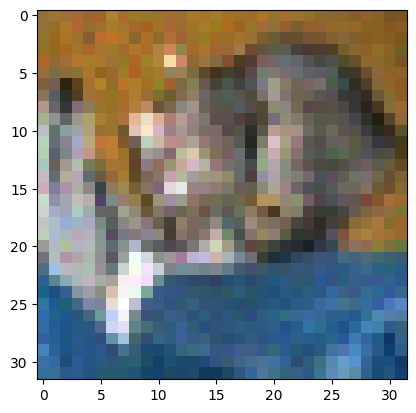

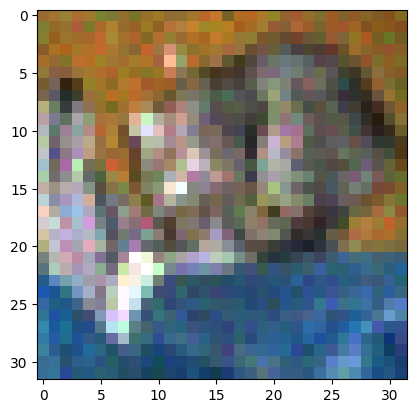

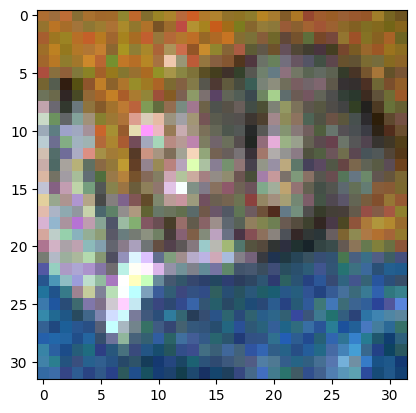

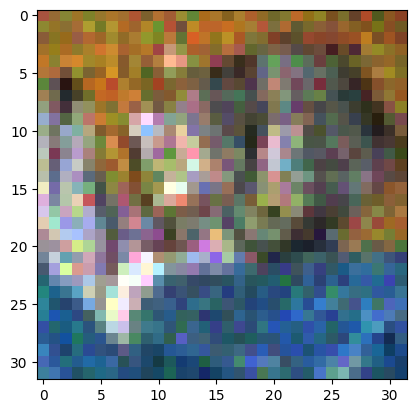

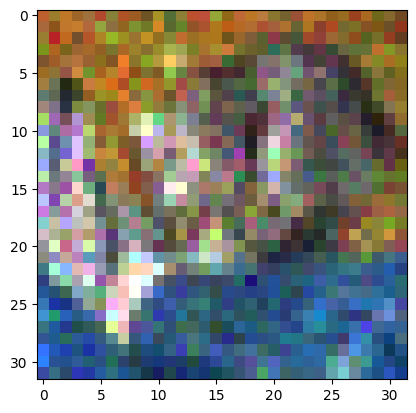

In [64]:

for sev in [1, 2, 3, 4, 5]:
    # test_loader_corrupt = get_corrupt_loader(batch_size=1024, corruption_type='zoom_blur', severity=sev, model_name='clip')
    # ims, _, _ = next(iter(test_loader_corrupt))
    ims=gaus[(sev-1)*10000: sev*10000]
    plt.imshow(ims[0])
    plt.show()

## Resnet results

In [3]:
train_loader, val_loader, test_loader = get_original_loaders(batch_size=1024, model_name='resnet')
test_corrupt_loader = get_corrupt_loaders(batch_size=1024, model_name='resnet')

sys.path.append('../')
from src.resnet import define_model, get_image_features, feature_dim
from src.build_classifier import get_classifier
from src.train_clf import train

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = 'cuda'

In [5]:
resnet_model = define_model(device=device).to(device)
resnet_clf = get_classifier(feature_dim, output_classes=10, n_layers=1).to(device)

/home/omoussa/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/omoussa/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import torch
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(resnet_clf.parameters(), lr=0.001)
n_epochs = 20

In [ ]:
losses, accs, val_losses, val_accs = train(resnet_model, resnet_clf, optim=optim, loss_fn=loss_fn,
                                           train_loader=train_loader, val_loader=val_loader,
                                           feature_fn=get_image_features, epochs=9, device=device)

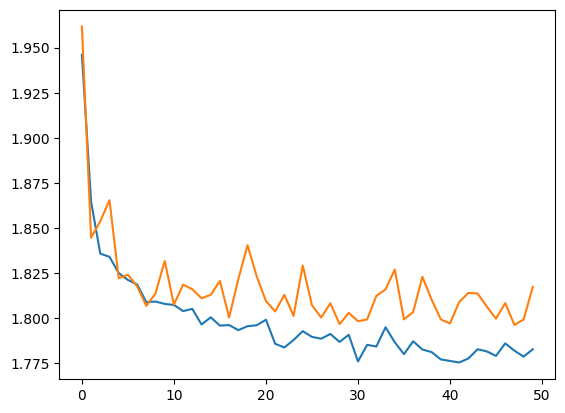

In [139]:
plt.plot(losses)
plt.plot(val_losses)

In [9]:
def get_acc(gt, preds = None):
    if preds is not None: 
        return ((preds.argmax(1)==gt).sum()/len(preds)).cpu().numpy()
        
    
    return ((preds.argmax(1)==gt).sum()/len(preds)).cpu().numpy()
    

def get_test_acc(emb_model, model, test_loader, feature_fn, device='cuda'):
    eval_acc = []
    eval_losses = []
    for eval_batch in test_loader:
        ims, labels = eval_batch
        ims, labels = ims.to(device), labels.to(device)
        with torch.no_grad():
            features = feature_fn(emb_model, ims).squeeze()
            preds = model(features)
            val_acc = get_acc(labels.view(-1,), preds)
        
        eval_acc.append(val_acc)
    
    return np.mean(eval_acc)
            

In [10]:
test_acc_orig = get_test_acc(resnet_model, resnet_clf, test_loader, get_image_features, device=device,
                             )

In [30]:
test_acc_s2_gaus= get_test_acc(resnet_model, resnet_clf, test_corrupt_loader, get_image_features, device=device,
                             )

In [35]:
corrupt_shot_acc = []
for sev in [1, 2, 3, 4, 5]:
    test_loader_corrupt = get_corrupt_loaders(batch_size=1024, corruption_type='shot_noise', severity=sev, model_name='resnet')
    acc =  get_test_acc(resnet_model, resnet_clf, test_loader_corrupt, get_image_features, device=device,
                             )

    corrupt_shot_acc.append(acc)

/home/omoussa/miniconda3/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [81]:
torch.save(resnet_clf.state_dict(), '../saved_models/resnet_clf.pth')


## CLIP

In [36]:
sys.path.append('../')
# from transformers import CLIPProcessor, CLIPModel

# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# def define_model(device='cuda'):
#     model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
#     return model

from src.clip import get_image_features
from src.build_classifier import get_classifier
from src.train_clf import train

In [38]:
# model = define_model(device).to(device)
device='cuda'
clip_clf = get_classifier(512, output_classes=10, n_layers=1).to(device)
train_loader, val_loader, test_loader = get_original_loaders(batch_size=1024, model_name='clip') 
test_corrupt_loader = get_corrupt_loaders(batch_size=1024, model_name='clip')

Files already downloaded and verified
Files already downloaded and verified


In [43]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import clip

model, preprocess = clip.load("ViT-B/32", device=device)
model = model.eval()

In [34]:
def get_image_features_clip(model, img_tensor, device='cuda'):

    with torch.no_grad():
        image_features = model.encode_image(img_tensor.to(device))
    return image_features.float()


In [35]:
im_b, _ = next(iter(train_loader))


In [36]:
ins = get_image_features_clip(model, im_b)

In [42]:
ins.dtype

torch.float32

In [37]:
import torch
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(clip_clf.parameters(), lr=0.001)
n_epochs = 20

NameError: name 'clip_clf' is not defined

In [44]:
losses, accs, val_losses, val_accs = train(model, clip_clf, optim=optim, loss_fn=loss_fn,
                                           train_loader=train_loader, val_loader=val_loader,
                                           feature_fn=get_image_features_clip, epochs=2, device=device) #TODO resize im in clip transforms

initial loss 2.3048531770706178 and initial accuracy 0.021496333181858063
 train loss: 1.7621201276779175, val loss: 1.5455564498901366, Train accuracy 0.821826159954071, val accuracy 0.9362683296203613 
 train loss: 1.5361000508069993, val loss: 1.5288676857948302, Train accuracy 0.9365478754043579, val accuracy 0.941360354423523 


In [49]:
torch.save(clip_clf.state_dict(), '../saved_models/clip_clf.pth')


In [39]:
clip_clf.load_state_dict(torch.load('../saved_models/clip_clf.pth', map_location=device))

<All keys matched successfully>

In [76]:
import os
import urllib.request
import tarfile
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image


device = "cuda" if torch.cuda.is_available() else "cpu"
import clip

modelss, preprocess = clip.load("ViT-B/32", device=device)
del modelss
class TestCorruptDataset(Dataset):
    def __init__(self, corruption_type="gaussian_noise", severity=2, model_name='clip'):
        self.corruption_type = corruption_type

        # Load the original CIFAR-10 dataset
        # self.cifar10_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

        # Load the corruption images
        directory = "../cifar/CIFAR-10-C"
        files = os.listdir(directory)
        self.corruption_images = {}
        # for file in files:
        #     corruption_type = os.path.splitext(file)[0]
        # numpy_array = np.load(os.path.join(directory, file))
        # self.corruption_images[corruption_type] = numpy_array
        
        self.corruption_images = np.load(f'../cifar/CIFAR-10-C/{corruption_type}.npy')
        self.corruption_images_list = self.corruption_images.copy()
        self.labels = np.load(f'../cifar/CIFAR-10-C/labels.npy') #self.corruption_images['labels'].copy()
        self.labels = self.labels[(severity-1)*10000: severity*10000]
        self.corruption_images_list = (self.corruption_images_list[(severity-1)*10000: severity*10000])
        self.corruption_images_pils = []
        for im in self.corruption_images_list:
            self.corruption_images_pils.append(Image.fromarray(im))
        # del  self.corruption_images[corruption_type]
         # Load the original CIFAR-10 dataset
        if model_name=='clip':
            data_transform = preprocess #transforms.Compose([transforms.ToTensor(),])
        elif model_name=='resnet':
            data_transform = transforms.Compose([ transforms.Resize(224), transforms.ToTensor(),
                                                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
        else:
            data_transform = transforms.Compose([transforms.ToTensor(),])
        
        self.transform = data_transform


    def __len__(self):
        return len(self.corruption_images_pils)

    


    def __getitem__(self, idx):
      # Generate random indexes with the same size as the number of images
    #   random_indexes = np.random.randint(len(self.cifar10_dataset), size=self.num_images)
      
      # Initialize empty lists for images, corrupted images, and labels
  

      # Iterate through the random indexes
    #   for index in random_indexes:

            # Select the corresponding corruption image
        corruption_image = self.corruption_images_pils[idx]
        label = self.labels[idx]

            # Use the same index for original and corrupted images
        #   corrupted_image = corruption_image[index]

        #   images.append(image)
        #   corrupted_images.append(corrupted_image)
        #   labels.append(label)
        return torch.from_numpy(np.array(corruption_image)), self.transform(corruption_image), label

def get_corrupt_loader(corruption_type='gaussian_noise', severity=2, batch_size=64, model_name='clip'):

    # Create an instance of the CustomDataset

    test_corrupt_dataset = TestCorruptDataset(corruption_type, severity=severity, model_name=model_name)
    test_corrup_dataloader = torch.utils.data.DataLoader(test_corrupt_dataset, batch_size=batch_size, shuffle=False)
    return test_corrup_dataloader
    

In [71]:
def get_acc(gt, preds = None):
    if preds is not None: 
        return ((preds.argmax(1)==gt).sum()/len(preds)).cpu().numpy()
        
    
    return ((preds.argmax(1)==gt).sum()/len(preds)).cpu().numpy()
    

def get_test_acc(emb_model, model, test_loader, feature_fn, device='cuda'):
    eval_acc = []
    eval_losses = []
    for eval_batch in test_loader:
        _, ims, labels = eval_batch
        ims, labels = ims.to(device), labels.to(device)
        with torch.no_grad():
            features = feature_fn(emb_model, ims).squeeze()
            preds = model(features)
            val_acc = get_acc(labels.view(-1,), preds)
        
        eval_acc.append(val_acc)
    
    return np.mean(eval_acc)
            # 
# test_acc_orig = get_test_acc(resnet_model, resnet_clf, test_loader, get_image_features, device=device,)
 


In [123]:
corruption_list = os.listdir('/DS/brn-vision/work/side_pr/HLCV23/cifar/CIFAR-10-C')
corruption_list.remove('labels.npy')
corruption_list = [v.replace('.npy', '') for v in corruption_list]

In [124]:
corruption_list

['snow',
 'brightness',
 'fog',
 'gaussian_blur',
 'elastic_transform',
 'spatter',
 'gaussian_noise',
 'zoom_blur',
 'speckle_noise',
 'contrast',
 'jpeg_compression',
 'motion_blur',
 'impulse_noise',
 'frost',
 'defocus_blur',
 'pixelate',
 'shot_noise',
 'glass_blur',
 'saturate']

In [19]:
test_loader_corrupt = get_corrupt_loader(batch_size=1024, corruption_type='gaussian_noise', severity=1, model_name='resnet')
racc =  get_test_acc(resnet_model, resnet_clf, test_loader_corrupt, get_image_features, device=device,)

In [20]:
racc

0.42551222

In [79]:
corrupts_dict_resnet = {}
corrupt_g_acc = []
for cr in ['gaussian_noise', 'speckle_noise', 'impulse_noise', 'shot_noise', ]:
    corrupts_dict_resnet[cr] = {}
    for sev in [1, 2, 3, 4, 5]:
        test_loader_corrupt = get_corrupt_loader(batch_size=1024, corruption_type=cr, severity=sev, model_name='resnet')
        acc =  get_test_acc(resnet_model, resnet_clf, test_loader_corrupt, get_image_features, device=device,)
                                

        corrupts_dict_resnet[cr][sev]=acc

In [80]:
corrupts_dict_resnet

{'gaussian_noise': {1: 0.42551222,
  2: 0.37223372,
  3: 0.3178691,
  4: 0.29713207,
  5: 0.27495813},
 'speckle_noise': {1: 0.4417271,
  2: 0.3915916,
  3: 0.36188418,
  4: 0.31456274,
  5: 0.27066925},
 'impulse_noise': {1: 0.40451807,
  2: 0.34161153,
  3: 0.29210776,
  4: 0.21476205,
  5: 0.18101084},
 'shot_noise': {1: 0.44331354,
  2: 0.4096859,
  3: 0.34197226,
  4: 0.3126654,
  5: 0.2765884}}

In [75]:
corrupts_dict_clip

{'gaussian_noise': {1: 0.78469384,
  2: 0.61554927,
  3: 0.46166295,
  4: 0.40353155,
  5: 0.3519631},
 'speckle_noise': {1: 0.853683,
  2: 0.7310168,
  3: 0.65623605,
  4: 0.51566684,
  5: 0.4116211},
 'impulse_noise': {1: 0.84971696,
  2: 0.748579,
  3: 0.6422413,
  4: 0.46899113,
  5: 0.3660156},
 'shot_noise': {1: 0.8506417,
  2: 0.77120936,
  3: 0.5612803,
  4: 0.48734856,
  5: 0.38184193}}

Text(0.5, 1.0, 'corruption accuracies resnet')

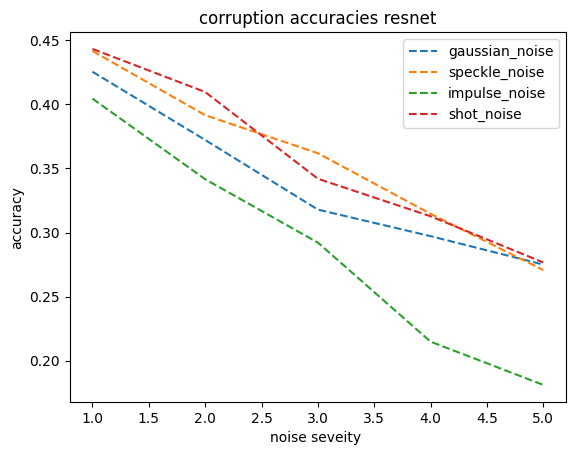

In [28]:
for k in ['gaussian_noise', 'speckle_noise', 'impulse_noise', 'shot_noise', ]:
    plt.plot([1, 2, 3, 4, 5], list(corrupts_dict_resnet[k].values()), '--')

plt.legend(['gaussian_noise', 'speckle_noise', 'impulse_noise', 'shot_noise', ])
plt.xlabel('noise seveity ')
plt.ylabel('accuracy')
plt.title('corruption accuracies resnet')

In [49]:
corrupts_dict_clip = {}
corrupt_g_acc = []
for cr in ['gaussian_noise', 'speckle_noise', 'impulse_noise', 'shot_noise', ]:
    corrupts_dict_clip[cr] = {}
    for sev in [1, 2, 3, 4, 5]:
        test_loader_corrupt = get_corrupt_loader(batch_size=1024, corruption_type=cr, severity=sev, model_name='clip')
        acc =  get_test_acc(model, clip_clf, test_loader_corrupt, get_image_features_clip, device=device,
                                )

        corrupts_dict_clip[cr][sev]=acc

In [ ]:
['gaussian_noise', 'speckle_noise', 'impulse_noise', 'shot_noise', ]

Text(0.5, 1.0, 'corruption accuracies ')

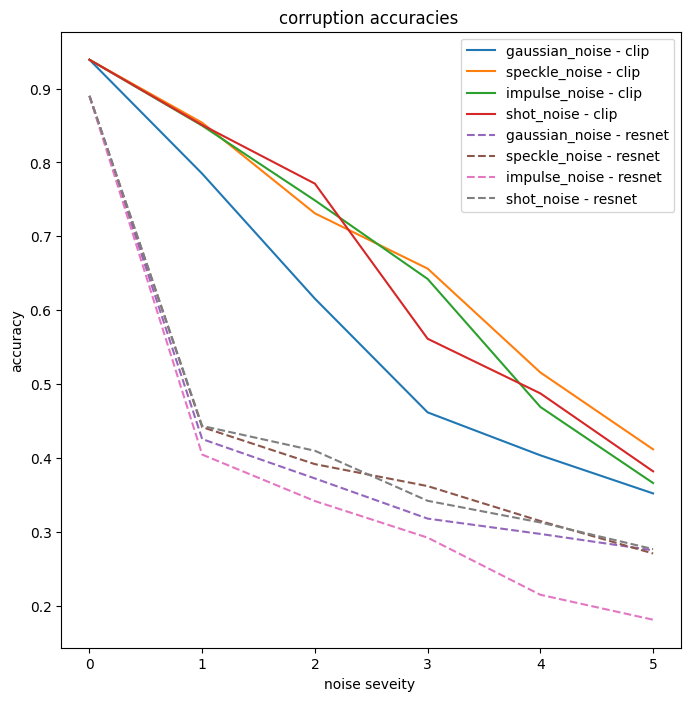

In [55]:
plt.figure(figsize=[8, 8])
for k in ['gaussian_noise', 'speckle_noise', 'impulse_noise', 'shot_noise', ]:
    plt.plot([0, 1, 2, 3, 4, 5], [0.93897283,] +list(corrupts_dict_clip[k].values()))

for k in ['gaussian_noise', 'speckle_noise', 'impulse_noise', 'shot_noise', ]:
    plt.plot([0, 1, 2, 3, 4, 5], [0.89, ] +list(corrupts_dict_resnet[k].values()), '--')
    
plt.legend(['gaussian_noise - clip', 'speckle_noise - clip', 'impulse_noise - clip', 'shot_noise - clip', 'gaussian_noise - resnet', 'speckle_noise - resnet', 'impulse_noise - resnet', 'shot_noise - resnet' ])
plt.xlabel('noise seveity ')
plt.ylabel('accuracy')
plt.title('corruption accuracies ')

## TODO: try DINO

In [ ]:
import torch 
vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')